In [15]:
from pathlib import Path
import json, csv, random
import numpy as np
import matplotlib.pyplot as plt
from time import sleep
from Bio import Entrez, SeqIO
from io import StringIO

Entrez.email = "estebanjbn@gmail.com"
Entrez.api_key = '48e1447c04bd5f1ddaedb6f7d325080ed409'  

BASE = Path("seq_align_assignment")
RESULTS = BASE / "results"
RESULTS.mkdir(parents=True, exist_ok=True)

print("Base:", BASE)
print("Results:", RESULTS)

Base: seq_align_assignment
Results: seq_align_assignment\results


## **Secuencias contra secuencia**

In [16]:
pairs_path = BASE / "pairs.json"
with open(pairs_path) as f:
    pairs = json.load(f)

len(pairs), [p["name"] for p in pairs][:5]

(10, ['Pair1', 'Pair2', 'Pair3', 'Pair4', 'Pair5'])

In [17]:
from alignment import needleman_wunsch, smith_waterman, markers

MATCH, MISMATCH, GAP = 2, -1, -2
MATCH, MISMATCH, GAP

(2, -1, -2)

In [18]:
def save_alignment_txt(title, a1, a2, match, mismatch, gap, outpath):
    marks, ident = markers(a1, a2)
    txt = f"""{title}
Params: match={match}, mismatch={mismatch}, gap={gap}
Aligned 1: {a1}
Matchers:  {marks}
Aligned 2: {a2}
Identity: {ident:.3f}
"""
    outpath.write_text(txt)
    return float(round(ident, 4))

def save_matrix_heatmap(score, path_coords, title, outfile):
    plt.figure(figsize=(6, 5))
    plt.imshow(score, aspect='auto')
    if path_coords:
        ys = [i for (i, j) in path_coords]
        xs = [j for (i, j) in path_coords]
        plt.plot(xs, ys, linewidth=1.5)
    plt.title(title)
    plt.xlabel("j")
    plt.ylabel("i")
    plt.tight_layout()
    plt.savefig(outfile)
    plt.close()

def run_once(pair, algo="NW", match=2, mismatch=-1, gap=-2):
    s1, s2 = pair["s1"], pair["s2"]
    if algo == "NW":
        score, ptr, a1, a2, best = needleman_wunsch(s1, s2, match, mismatch, gap)
        path = None
        title = f"{pair['name']} Global (NW) score={best}"
    else:
        score, ptr, a1, a2, best = smith_waterman(s1, s2, match, mismatch, gap)
        path = None
        title = f"{pair['name']} Local (SW) score={best}"

    txt_path = RESULTS / f"{pair['name']}_{algo}_alignment.txt"
    png_path = RESULTS / f"{pair['name']}_{algo}_matrix.png"
    identity = save_alignment_txt(title, a1, a2, match, mismatch, gap, txt_path)
    save_matrix_heatmap(score, path, title, png_path)

    return {
        "pair": pair["name"], "algo": algo, "score": int(best),
        "identity": identity,
        "match": match, "mismatch": mismatch, "gap": gap,
        "alignment_txt": str(txt_path),
        "heatmap_png": str(png_path),
    }

In [19]:
summary = []

for p in pairs:
    summary.append(run_once(p, "NW", MATCH, MISMATCH, GAP))
    summary.append(run_once(p, "SW", MATCH, MISMATCH, GAP))

with open(RESULTS / "summary.json", "w") as f:
    json.dump(summary, f, indent=2)

import csv
with open(RESULTS / "summary.csv", "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["pair","algo","score","identity","match","mismatch","gap","alignment_txt","heatmap_png"])
    for r in summary:
        w.writerow([r["pair"], r["algo"], r["score"], r["identity"], r["match"], r["mismatch"], r["gap"], r["alignment_txt"], r["heatmap_png"]])

print("Listo baseline. Registros en summary:", len(summary))
(RESULTS / "summary.csv")

Listo baseline. Registros en summary: 20


WindowsPath('seq_align_assignment/results/summary.csv')

In [20]:
import pandas as pd
df = pd.read_csv(RESULTS / "summary.csv")
df.head(10)

,pair,algo,score,identity,match,mismatch,gap,alignment_txt,heatmap_png
0,Pair1,NW,52,0.0124,2,-1,-2,seq_align_assignment\results\Pair1_NW_alignmen...,seq_align_assignment\results\Pair1_NW_matrix.png
1,Pair1,SW,56,0.5800,2,-1,-2,seq_align_assignment\results\Pair1_SW_alignmen...,seq_align_assignment\results\Pair1_SW_matrix.png
2,Pair2,NW,49,0.0183,2,-1,-2,seq_align_assignment\results\Pair2_NW_alignmen...,seq_align_assignment\results\Pair2_NW_matrix.png
3,Pair2,SW,56,0.6620,2,-1,-2,seq_align_assignment\results\Pair2_SW_alignmen...,seq_align_assignment\results\Pair2_SW_matrix.png
4,Pair3,NW,114,0.0000,2,-1,-2,seq_align_assignment\results\Pair3_NW_alignmen...,seq_align_assignment\results\Pair3_NW_matrix.png
5,Pair3,SW,121,0.7935,2,-1,-2,seq_align_assignment\results\Pair3_SW_alignmen...,seq_align_assignment\results\Pair3_SW_matrix.png
6,Pair4,NW,60,0.0122,2,-1,-2,seq_align_assignment\results\Pair4_NW_alignmen...,seq_align_assignment\results\Pair4_NW_matrix.png
7,Pair4,SW,66,0.6146,2,-1,-2,seq_align_assignment\results\Pair4_SW_alignmen...,seq_align_assignment\results\Pair4_SW_matrix.png
8,Pair5,NW,153,0.0000,2,-1,-2,seq_align_assignment\results\Pair5_NW_alignmen...,seq_align_assignment\results\Pair5_NW_matrix.png
9,Pair5,SW,162,0.9651,2,-1,-2,seq_align_assignment\results\Pair5_SW_alignmen...,seq_align_assignment\results\Pair5_SW_matrix.png


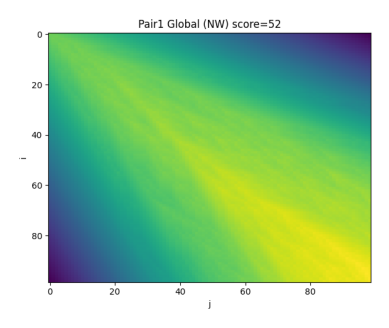

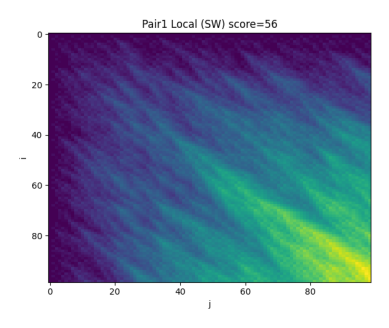

In [21]:
import matplotlib.pyplot as plt
from PIL import Image

ejemplos = df.head(2)["heatmap_png"].tolist()
for path in ejemplos:
    img = Image.open(path)
    plt.figure(figsize=(5,4))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

## **Secuencias contra Gen Humano**

In [22]:
def fetch_fasta_by_accession(accession: str) -> str:
    with Entrez.efetch(db="nucleotide", id=accession, rettype="fasta", retmode="text") as h:
        return h.read()

def fetch_fasta_slice(accession: str, start: int, end: int, strand: int = 1) -> str:
    with Entrez.efetch(
        db="nucleotide", id=accession, rettype="fasta", retmode="text",
        strand=strand, seq_start=start, seq_stop=end
    ) as h:
        return h.read()

from Bio.Seq import Seq

def fasta_to_seqstring(fasta_text: str) -> str:
    rec = SeqIO.read(StringIO(fasta_text), "fasta")
    return str(rec.seq).upper()

def rev(seq: str) -> str:
    return seq[::-1]

def revcomp(seq: str) -> str:
    return str(Seq(seq).reverse_complement()).upper()

In [23]:
pairs_path = BASE / "pairs.json"
with open(pairs_path) as f:
    pairs = json.load(f)

def get_my_sequences(which="s1"):  # "s1", "s2" o "both"
    seqs = []
    for p in pairs:
        if which in ("s1", "both"):
            seqs.append((p["name"]+"_s1", p["s1"].upper()))
        if which in ("s2", "both"):
            seqs.append((p["name"]+"_s2", p["s2"].upper()))
    return seqs

my_sequences = get_my_sequences(which="s1")  # cámbialo a "both" si quieres las 20
len(my_sequences), my_sequences[0][0], my_sequences[0][1][:40]

(10, 'Pair1_s1', 'GACTTACGCGCCGTAGCACTTCTGTGATAGCTGCGAGGCG')

In [29]:
# A) Mitocondrial humana
mt_acc = "NC_012920.1"
mt_fasta = fetch_fasta_by_accession(mt_acc)
ref_full = fasta_to_seqstring(mt_fasta)
len(ref_full)

16569

In [ ]:
# Recorta una ventana de referencia (ajusta posiciones a tu gusto)
ref = ref_full[2000:5000]  # ~3000 bp; puedes bajar a 1500–2000 si tu PC es modesta
len(ref), ref[:60]

(3000, 'CGAGCCTGGTGATAGCTGGTTGTCCAAGATAGAATCTTAGTTCAACTTTAAATTTGCCCA')

In [31]:
from alignment import needleman_wunsch, smith_waterman, markers
import matplotlib.pyplot as plt
import numpy as np

def save_heatmap(score_matrix, title, out_png: Path):
    plt.figure(figsize=(6,5))
    plt.imshow(score_matrix, aspect='auto')
    plt.title(title); plt.xlabel("j"); plt.ylabel("i")
    plt.tight_layout(); plt.savefig(out_png); plt.close()

def align_and_save(pair_name, s1, s2, algo="NW", match=2, mismatch=-1, gap=-2, outdir=RESULTS):
    outdir.mkdir(parents=True, exist_ok=True)
    if algo.upper() == "NW":
        score, ptr, a1, a2, total = needleman_wunsch(s1, s2, match, mismatch, gap)
        best = total
        title = f"{pair_name} — NW score={best}"
    else:
        score, ptr, a1, a2, best = smith_waterman(s1, s2, match, mismatch, gap)
        title = f"{pair_name} — SW best={best}"

    bars, ident = markers(a1, a2)
    txt = (
        f"{title}\n"
        f"params: match={match}, mismatch={mismatch}, gap={gap}\n"
        f"Aligned 1: {a1}\n"
        f"Matchers : {bars}\n"
        f"Aligned 2: {a2}\n"
        f"Identity: {ident:.3f}\n"
    )
    (outdir / f"{pair_name}_{algo}.txt").write_text(txt)
    save_heatmap(score, title, outdir / f"{pair_name}_{algo}_matrix.png")
    return best, ident

In [33]:
MATCH, MISMATCH, GAP = 2, -1, -2  # parámetros base

def compare_all_against_ref(ref_seq: str, my_seqs, use_rev=True, use_revcomp=True,
                            do_txt_png=False, algo_list=("NW","SW")):
    summary = []
    for name, q in my_seqs:
        variants = [("forward", q)]
        if use_rev:
            variants.append(("reverse", rev(q)))
        if use_revcomp:
            variants.append(("revcomp", revcomp(q)))

        for variant_name, qv in variants:
            for algo in algo_list:
                pair_name = f"{name}_vs_REF_{variant_name}"
                if do_txt_png:
                    best, ident = align_and_save(pair_name, ref_seq, qv, algo=algo,
                                                 match=MATCH, mismatch=MISMATCH, gap=GAP)
                else:
                    # Si no quieres generar archivos, solo calcula
                    if algo == "NW":
                        score, ptr, a1, a2, best = needleman_wunsch(ref_seq, qv, MATCH, MISMATCH, GAP)
                    else:
                        score, ptr, a1, a2, best = smith_waterman(ref_seq, qv, MATCH, MISMATCH, GAP)
                    _, ident = markers(a1, a2)

                summary.append({
                    "query": name,
                    "variant": variant_name,
                    "algo": algo,
                    "score_or_best": int(best),
                    "identity": float(round(ident, 4)),
                    "len_ref": len(ref_seq),
                    "len_query": len(qv)
                })
    return summary

summary = compare_all_against_ref(ref, my_sequences, use_rev=True, use_revcomp=True,
                                  do_txt_png=False, algo_list=("NW","SW"))
len(summary), summary[:3]


(60,
 [{'query': 'Pair1_s1',
   'variant': 'forward',
   'algo': 'NW',
   'score_or_best': -5608,
   'identity': 0.0,
   'len_ref': 3000,
   'len_query': 98},
  {'query': 'Pair1_s1',
   'variant': 'forward',
   'algo': 'SW',
   'score_or_best': 67,
   'identity': 0.5909,
   'len_ref': 3000,
   'len_query': 98},
  {'query': 'Pair1_s1',
   'variant': 'reverse',
   'algo': 'NW',
   'score_or_best': -5608,
   'identity': 0.0,
   'len_ref': 3000,
   'len_query': 98}])

In [34]:
import pandas as pd

df = pd.DataFrame(summary)
df.sort_values(["algo","identity","score_or_best"], ascending=[True, False, False], inplace=True)
display(df)

out_csv = RESULTS / "summary_ref_vs_my10.csv"
df.to_csv(out_csv, index=False)
out_csv


,query,variant,algo,score_or_best,identity,len_ref,len_query
0,Pair1_s1,forward,NW,-5608,0.0000,3000,98
2,Pair1_s1,reverse,NW,-5608,0.0000,3000,98
4,Pair1_s1,revcomp,NW,-5608,0.0000,3000,98
6,Pair2_s1,forward,NW,-5612,0.0000,3000,97
8,Pair2_s1,reverse,NW,-5612,0.0000,3000,97
10,Pair2_s1,revcomp,NW,-5612,0.0000,3000,97
24,Pair5_s1,forward,NW,-5620,0.0000,3000,95
26,Pair5_s1,reverse,NW,-5620,0.0000,3000,95
28,Pair5_s1,revcomp,NW,-5620,0.0000,3000,95
12,Pair3_s1,forward,NW,-5624,0.0000,3000,94


WindowsPath('seq_align_assignment/results/summary_ref_vs_my10.csv')